In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from astropy import stats
from astropy.io import fits,ascii
import sys, getopt
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import signal

#matplotlib settings for pretty plots

#matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
mpl.rc('font', **font)


In [2]:
path = '/Users/kevinm/Documents/UCSC/Year2/Quarter2/Astro257/HW5_data/'
filenames = ['ARC.fits',
            'EGGR_17.fits',
            'hz14.fits',
            'ic348_h209.fits',
            'LB1839_praesepe.fits',
            'n2168_RA3.fits',
            'n2168_RA4.fits',
            'n2168_vH1.fits',
            'n2168_WB1.fits',
            'n2168_WB2a.fits',
            'n2168_WB2b.fits',
            'n2168_WB3.fits',
            'n2168_WB4.fits',
            'n2168_WB5.fits',
            'n2168_WB6.fits',
            'n2168_WB7.fits',
            'n2168_WB9.fits',
            'n2168_WBB2a.fits',
            'n2168_WBB2b.fits',
            'PG0048+202.fits',
            'quartz_flat.fits',
            'WD0001+433.fits',
            'WD0834_praesepe.fits',
            'WD0937+505.fits',
            'WD1105-048.fits']

calibFile = f'{path}hz14.dat'
hz14_calib = np.genfromtxt(calibFile,names=('wave','mag','width'))

hz14 = fits.open(f'{path}{filenames[2]}')
arc = fits.open(f'{path}{filenames[0]}')


In [3]:
quartz = fits.open(f'{path}quartz_flat.fits')
print(quartz[0].header['TTIME'])

70


In [4]:
file = fits.open(f'{path}{filenames[5]}')

In [5]:
file[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                  606 / Axis length                                    
NAXIS2  =                 2650 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '16:14:51 (26/05/2004)' / Time of last modification                   
OBJECT  = 'n2168 RA 3'         / Name of the object observed                    
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition do

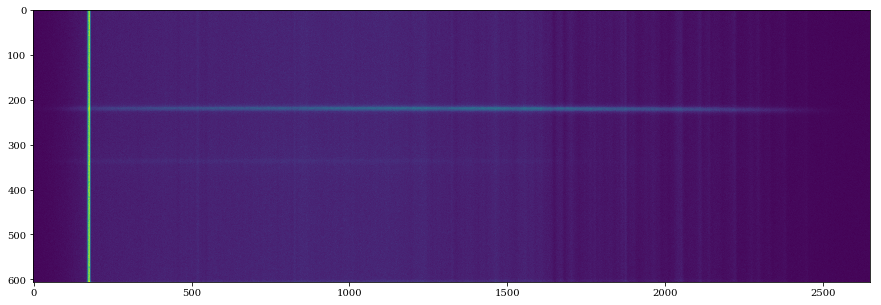

In [6]:
plt.figure(figsize=[15,5])
plt.imshow(file[0].data.T,aspect='auto')
plt.show()

In [7]:
file[0].data

array([[ 4.8868103 ,  3.7564392 ,  0.9775696 , ...,  1.9775696 ,
         2.3868103 ,  3.6677856 ],
       [ 4.475403  ,  2.4754028 ,  1.7543335 , ...,  5.166107  ,
         1.8854065 ,  3.3854065 ],
       [ 1.8839722 ,  1.4717712 ,  3.6645203 , ...,  2.6645203 ,
         2.6630554 ,  2.9717712 ],
       ...,
       [ 1.5396423 ,  0.31469727,  1.6451416 , ...,  2.3146973 ,
         1.3132935 , -0.45895386],
       [-0.18374634, -1.3530273 ,  1.1469727 , ...,  1.6469727 ,
         2.6469727 ,  0.14697266],
       [ 2.2122498 ,  1.6487427 ,  1.8166809 , ...,  0.3177185 ,
         0.5432739 ,  2.8177185 ]], dtype=float32)

In [8]:
# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma, C = p
    return A*np.exp(-np.power((x-mu),2)/(2.*np.power(sigma,2))) + C


def extractSpectrum(filename,path=path,rows=5,plotter=False):
    #rows = number of padded rows around the fit trace (i.e. 1+2*(rows) are used in 1d collapse)
    file = fits.open(f'{path}{filename}')
    expTime = file[0].header['TTIME']
    
    quartz = fits.open(f'{path}quartz_flat.fits')
    expTime_quartz = quartz[0].header['TTIME']
    
    rawdata = file[0].data.T[:,::-1].T/expTime
    rawdata_quartz = quartz[0].data.T[:,::-1].T/expTime_quartz
    
    rawdata /= rawdata_quartz
    if plotter:
        plt.figure(figsize=[10,5*2])
        ax = plt.subplot(3,1,1)
        ax.set_xticks([])
        #plt.imshow(file[0].data.T,aspect='auto')
        plt.ylabel('Row (pixels)')
        plt.imshow(rawdata.T,aspect='auto')
        #plt.show()
    
    trim = (100,200)
    trace = np.arange(0,rawdata.shape[0]),np.argmax(rawdata[:,trim[0]:-trim[1]],axis=1)+trim[0]
    
    medTrace = np.median(trace[1])
    goodtrace = np.abs(trace[1]-medTrace) < 20
    
    tracedeg = 3
    tracefit = np.polyfit(trace[0][goodtrace], trace[1][goodtrace], tracedeg)
    tracepoly = np.poly1d(tracefit)
    
    if plotter:
        #plt.figure(figsize=[15,5])
        ax = plt.subplot(3,1,2)
        ax.set_xticks([])
        plt.scatter(trace[0],trace[1],s=1,label='Row Maximum')
        plt.plot(trace[0],tracepoly(trace[0]),c='C1',label='Deg %d Polynomial Fit'%tracedeg)
        plt.xlim(0,file[0].data.shape[0])
        plt.ylabel('Row Maximum Location (pixels)')
        plt.legend(loc='best')
        #plt.show()
    
    inds = np.round(tracepoly(trace[0]),0).astype(int)
    meanInd = int(np.average(inds))

    rowave = np.average(rawdata[:,meanInd-50:meanInd+50],axis=0)

    # p0 is the initial guess for the fitting coefficients (A, mu, sigma, and C as described above)
    p0 = [np.max(rowave), np.argmax(rowave), 3., np.min(rowave)]

    coeff, var_matrix = curve_fit(gauss, np.arange(len(rowave)), rowave, p0=p0)
    coeff[1] += meanInd-50
    p0[1] += meanInd-50
    
    # Get the fitted curve
    hist_fit = gauss(np.arange(len(rowave))+meanInd-50, *coeff)
    first_fit = gauss(np.arange(len(rowave))+meanInd-50, *p0)

#     plt.figure(figsize=[15,5])
#     plt.plot(np.arange(len(rowave))+meanInd-50,rowave, label='Data')
#     plt.plot(np.arange(len(rowave))+meanInd-50,first_fit, label='First Guess')
#     plt.plot(np.arange(len(rowave))+meanInd-50,hist_fit, label='Fitted data')
#     plt.xlim(coeff[1]-coeff[2]*5,coeff[1]+coeff[2]*5)
#     plt.axvline(coeff[1]-coeff[2]*3,c='r',ls='--')
#     plt.axvline(coeff[1]+coeff[2]*3,c='r',ls='--')
#     plt.legend(loc='best')
#     plt.show()

    objInds = int(np.round(coeff[2]*3,0))
        
    data = np.zeros(len(trace[0]))
    sky = np.zeros(len(trace[0]))
    err = np.zeros(len(trace[0]))
    for i in range(len(inds)):
        skyInds = np.arange(rawdata.shape[1])
        skyInds = skyInds[np.logical_or(np.logical_and(skyInds < inds[i]-3*objInds,skyInds >= 10),np.logical_and(skyInds > inds[i]+3*objInds,skyInds < file[0].data.shape[1]-10))]
        data[i] = np.average(rawdata[i,inds[i]-3*objInds:inds[i]+3*objInds+1])
        sky[i] = np.average(rawdata[i,skyInds])
        err[i] = np.std(rawdata[i,skyInds])
    obj = data-sky
    
    if plotter:
        #plt.figure(figsize=[15,5])
        ax = plt.subplot(3,1,3)

        plt.errorbar(np.arange(len(data)),data,ms=1,fmt='o',label='total')
        plt.errorbar(np.arange(len(sky)),sky,ms=1,fmt='o',label='sky')
        plt.errorbar(np.arange(len(obj)),obj,ms=1,fmt='o',label='object')
        plt.xlim(0,rawdata.shape[0])
        plt.ylabel('Intensity (counts/sec)')
        plt.xlabel('Column (pixels)')
        plt.legend(loc='best',markerscale=10)
        plt.tight_layout()
        plt.savefig('HW5-%s_extract.png'%filename.split('.')[0])
        plt.show()
    
    return obj,sky,err

def extractArc(filename,path=path,rows=15,peaks=True,center=-1):
    #rows = number of padded rows around the fit trace (i.e. 1+2*(rows) are used in 1d collapse)
    file = fits.open(f'{path}{filename}')
    expTime = file[0].header['TTIME']
    rawdata = file[0].data.T[:,::-1].T/expTime

    
    plt.figure(figsize=[10,5*2/3*2])
    ax = plt.subplot(2,1,1)
    plt.imshow(rawdata.T,aspect='auto')
    plt.ylabel('Row (pixels)')
    plt.xticks([])
    #plt.show()
    
    trim = (50,50)
    if center == -1:
        center = np.arange(rawdata.shape[1])
        center = center[(center > trim[0]) & (center < len(center) - trim[1])]
        center = center[len(center)//2]
    
    data = np.zeros(rawdata.shape[0])
    for i in range(len(data)):
        skyInds = np.arange(rawdata.shape[1])
        skyInds = skyInds[(skyInds > trim[0]) & (skyInds < len(skyInds)-trim[1]) & (skyInds > center-trim[0]) & (skyInds < center+trim[1]+1)]
        data[i] = np.average(rawdata[i,skyInds])
    
    #plt.figure(figsize=[15,5])
    ax = plt.subplot(2,1,2)
    plt.plot(data)
    plt.xlim(0,rawdata.shape[0])
    plt.tight_layout()
    plt.ylabel('Intensity (counts/sec)')
    plt.xlabel('Column (pixels)')
    plt.tight_layout()
    plt.savefig('HW5-arcExtract.png')
    plt.show()
    
    if peaks:
        return data
    else:
        return data

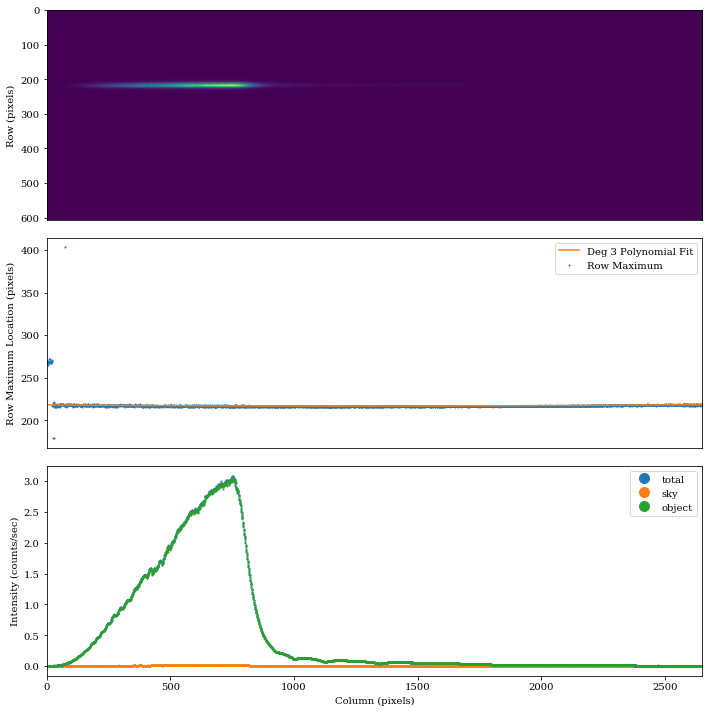

In [9]:
hz14 = extractSpectrum(filenames[2],path=path,plotter=True)

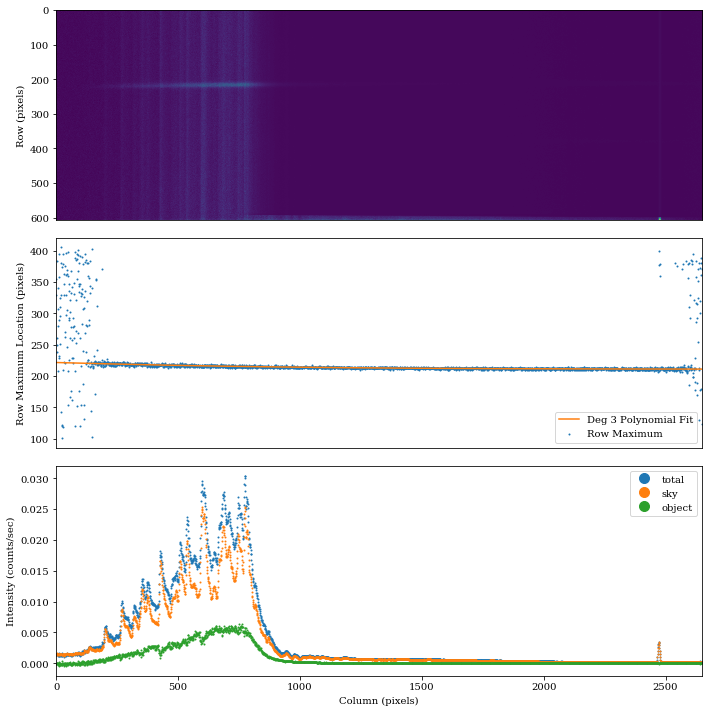

n2168_RA4.fits


In [10]:
test = extractSpectrum(filenames[6],path=path,plotter=True)
print(filenames[6])

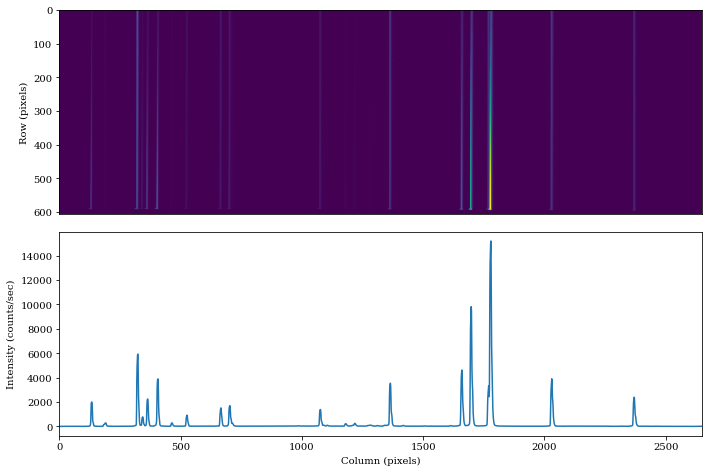

In [11]:
arc = extractArc(filenames[0],path=path)

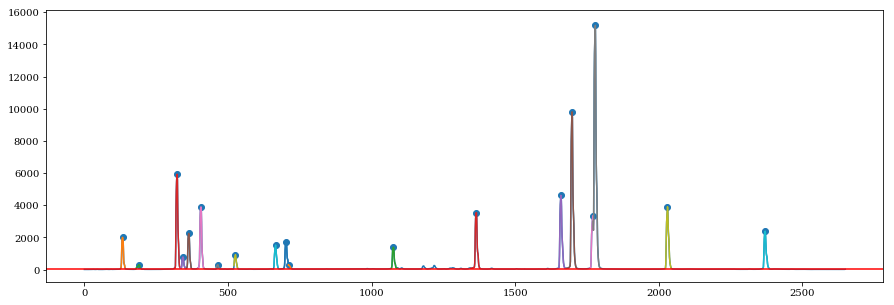

In [12]:
maxes = np.r_[True, arc[1:] > arc[:-1]] & np.r_[arc[:-1] > arc[1:], True]
threshhold = np.median(arc)
maxes = np.where(maxes & (arc > threshhold*10))
x = np.arange(len(arc))

peaks = []
for maxInd in maxes[0]:
    #walk forward
    newPeak = [maxInd]
    i = maxInd+1
    heightChange = arc[i]-arc[i-1]
    while ((heightChange < 0) or abs(arc[i]-arc[maxInd])/arc[maxInd] < 0.10) and arc[i] > threshhold*3:
        heightChange = arc[i]-arc[i-1]
        newPeak.append(i)
        i += 1
    #walk backwards
    i = maxInd-1
    heightChange = arc[i]-arc[i+1]
    while ((heightChange < 0) or abs(arc[i]-arc[maxInd])/arc[maxInd] < 0.10) and arc[i] > threshhold*3:
        heightChange = arc[i]-arc[i+1]
        newPeak.insert(0,i)
        i -= 1
    peaks.append(np.array(newPeak))

plt.figure(figsize=[15,5])
plt.plot(arc)
plt.scatter(x[maxes],arc[maxes])
[plt.plot(x[peak],arc[peak]) for peak in peaks]
plt.axhline(threshhold,c='r')
plt.show()



/Users/kevinm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


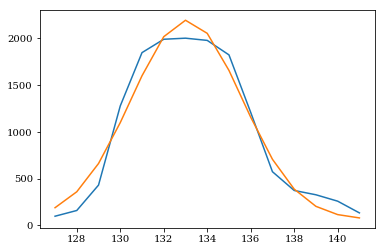

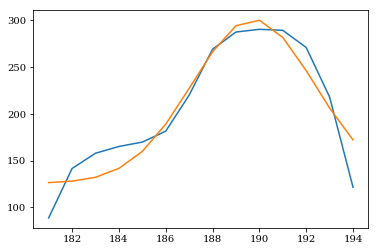

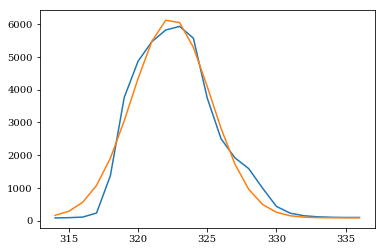

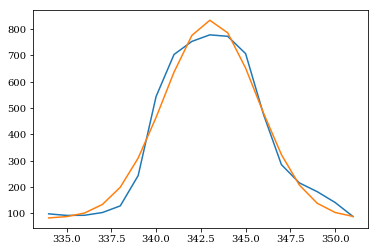

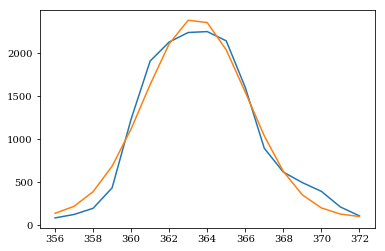

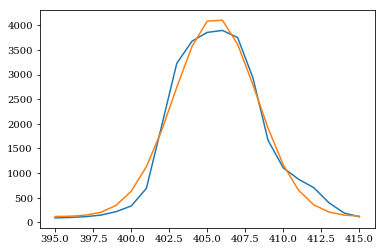

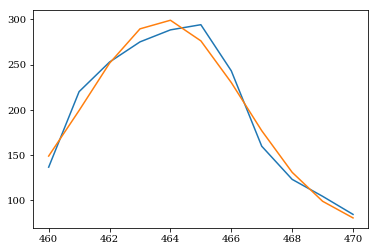

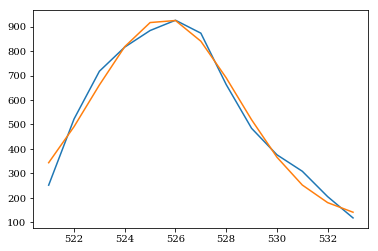

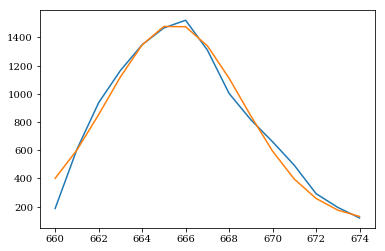

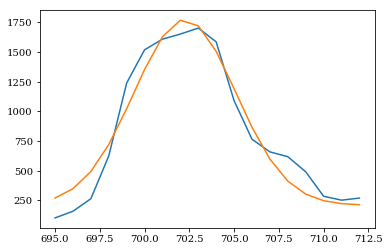

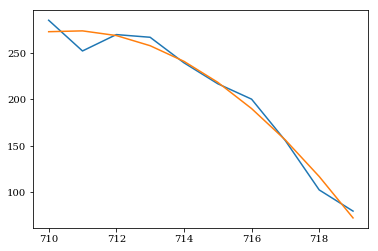

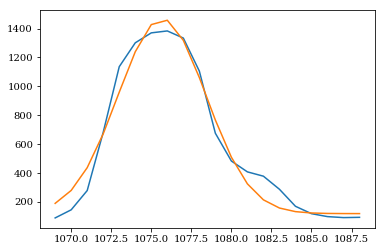

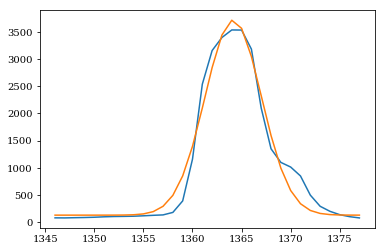

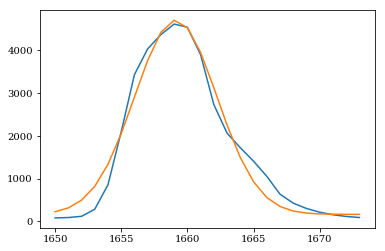

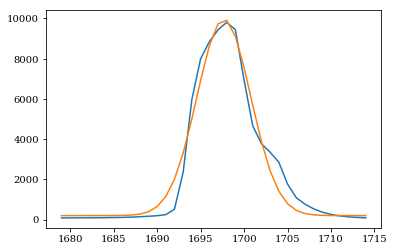

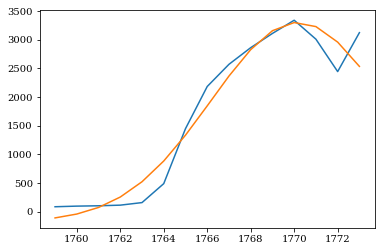

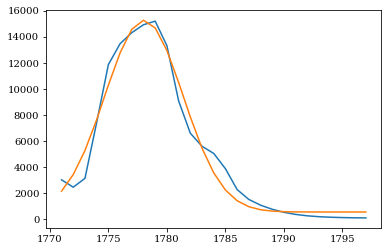

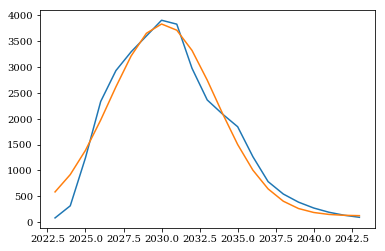

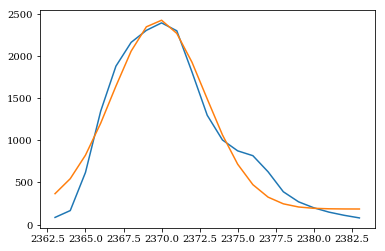

In [13]:
def gauss2(x, *p):
    A, mu, sigma, C = p
    return A*np.exp(-np.power((x-mu),2)/(2.*np.power(sigma,2)))+C

results = np.zeros((len(peaks),4))
errors = np.zeros((len(peaks),4))
for i,peak in enumerate(peaks):
    xvals,yvals = x[peak],arc[peak]
    p0 = [np.max(yvals), xvals[np.argmax(yvals)], 5., threshhold]

    coeff, var_matrix = curve_fit(gauss2, xvals, yvals, p0=p0)
    
    results[i] = coeff
    errors[i] = np.diag(np.sqrt(var_matrix))
    # Get the fitted curve
    hist_fit = gauss2(xvals, *coeff)
    plt.plot(xvals,yvals)
    plt.plot(xvals,hist_fit)
    plt.show()

    
    

In [14]:
#names = np.genfromtxt(f'{path}LRISZnHgCd.dat',dtype=str)
names = np.genfromtxt(f'{path}400_arc.list',dtype=str)
lines = names[:,0].astype(float)
names = names[:,1]

In [15]:
peakMap = {2:3252.5240,-1:5460.7350,-2:5085.8220,-3:4810.5300}

# 3252.5240 #CdI -> Red Peak (ind 2)
# 5460.7350 #HgI -> Red Peak (ind -1)
# 5085.8220 #CdI -> Red Peak (ind -2)
# 4810.5300 #ZnI -> Red Peak (ind -3)

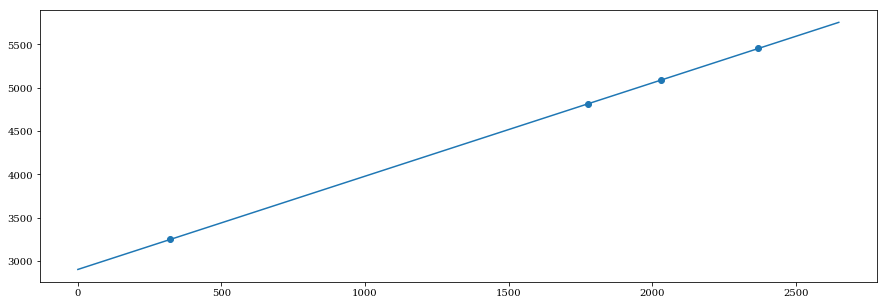

In [16]:
plt.figure(figsize=[15,5])

firstGuesses = []
for ind in peakMap:
    plt.scatter(results[:,1][ind],peakMap[ind],c='C0')
    firstGuesses.append((results[:,1][ind],peakMap[ind]))
firstGuesses = np.array(firstGuesses)    

waveGuessInds = np.array([2,-1,-2,-3])
wavefitnew = np.polyfit(firstGuesses[:,0], firstGuesses[:,1], 1)
wavepolynew = np.poly1d(wavefitnew)
xvals = np.linspace(0,len(hz14[0]))

plt.plot(xvals,wavepolynew(xvals))
plt.show()

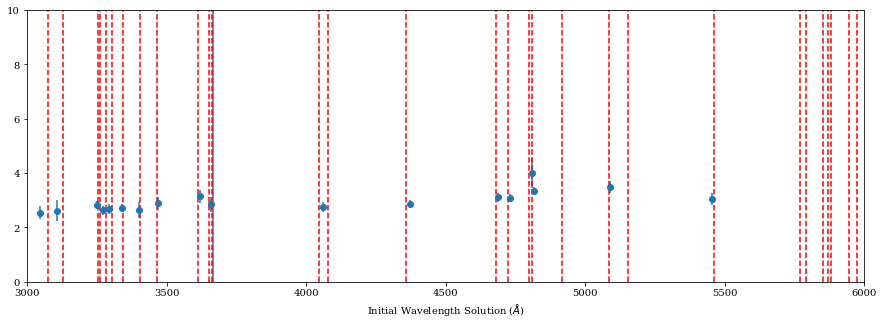

In [17]:
plt.figure(figsize=[15,5])
plt.errorbar(wavepolynew(results[:,1]),results[:,2],yerr=errors[:,2],fmt='o')
[plt.axvline(line,c='r',ls='--') for line in lines]
plt.ylim(0,10)
plt.xlabel('Initial Wavelength Solution ($\AA$)')
plt.xlim(3000,6000)
plt.show()

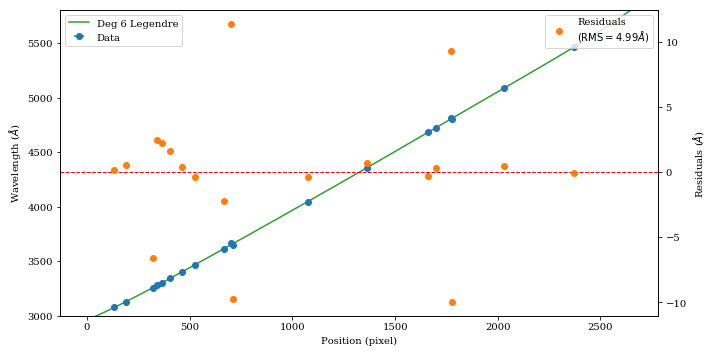

In [18]:
plt.figure(figsize=[10,5])

wavelengthpoints = np.zeros((len(results),3))
for i in range(len(results)):
    orderedLines = np.argsort(np.abs(lines-wavepolynew(results[i,1])))
    j = 0
    while lines[orderedLines[j]] in wavelengthpoints[:,1]:
        j += 1
    if i == 0:
        plt.errorbar(results[i,1],lines[orderedLines[j]],xerr=errors[i,1],c='C0',fmt='o',label='Data')
    else:
        plt.errorbar(results[i,1],lines[orderedLines[j]],xerr=errors[i,1],c='C0',fmt='o')
    wavelengthpoints[i] = (results[i,1],lines[orderedLines[j]],errors[i,1])
wavelengthpoints = np.array(wavelengthpoints)    

deg = 6
wavefitfinal = np.polyfit(wavelengthpoints[:,0], wavelengthpoints[:,1], deg)
wavepolyfinal = np.poly1d(wavefitfinal)
xvals = np.linspace(0,len(hz14[0]))

legdeg = 6
wavefitfinal_leg = np.polynomial.legendre.legfit(wavelengthpoints[:,0], wavelengthpoints[:,1], legdeg)
wavepolyfinal_leg = np.polynomial.legendre.legval(xvals,wavefitfinal_leg)

#plt.plot(xvals,wavepolyfinal(xvals),c='C1',label='Deg %d Polynomial'%deg)
plt.plot(xvals,wavepolyfinal_leg,c='C2',label='Deg %d Legendre'%legdeg)
plt.legend(loc='best')
plt.ylim(3000,min(8000,wavepolyfinal(xvals[-1])))
plt.ylabel('Wavelength ($\AA$)')
plt.xlabel('Position (pixel)')
ax = plt.gca()
ax1 = ax.twinx()
resids = wavelengthpoints[:,1]-np.polynomial.legendre.legval(wavelengthpoints[:,0],wavefitfinal_leg)

rms = np.sqrt(np.mean(np.power(resids,2)))
plt.errorbar(wavelengthpoints[:,0],resids,c='C1',fmt='o',label='Residuals\n$(\mathrm{RMS} = %.2f \AA)$'%rms)
plt.axhline(0,ls='--',c='r',lw=1)
plt.legend(loc='best')
plt.ylabel('Residuals ($\AA$)')
plt.tight_layout()
plt.savefig('HW5-waveSolution.png')
plt.show()


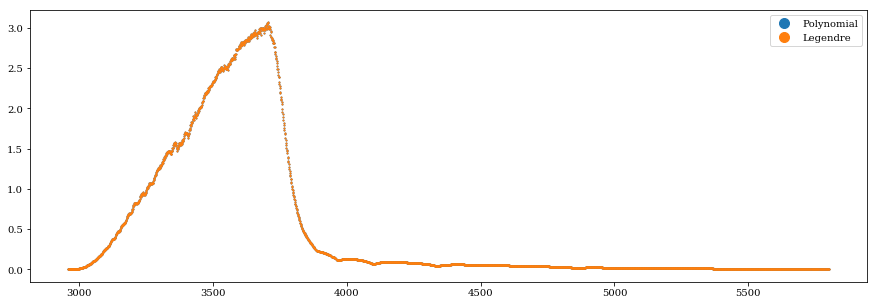

In [19]:
plt.figure(figsize=[15,5])

xvals = np.arange(len(hz14[0]))
plt.errorbar(wavepolyfinal(xvals),hz14[0],ms=1,fmt='o',label='Polynomial')
plt.errorbar(np.polynomial.legendre.legval(xvals,wavefitfinal_leg),hz14[0],ms=1,fmt='o',label='Legendre')
#plt.xlim(0,xvals)
plt.legend(loc='best',markerscale=10)
plt.show()

{'line1': 4341.634538571081, 'line2': 4102.844638949672, 'line3': 3971.148391279682, 'line4': 3890.1045465596885}


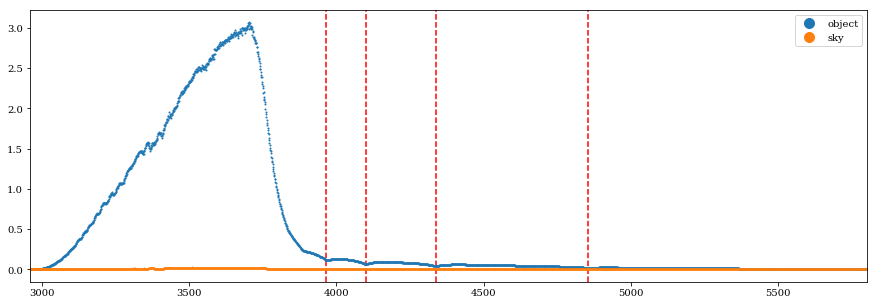

[ 9.82587703e-01 -3.76721450e+03]


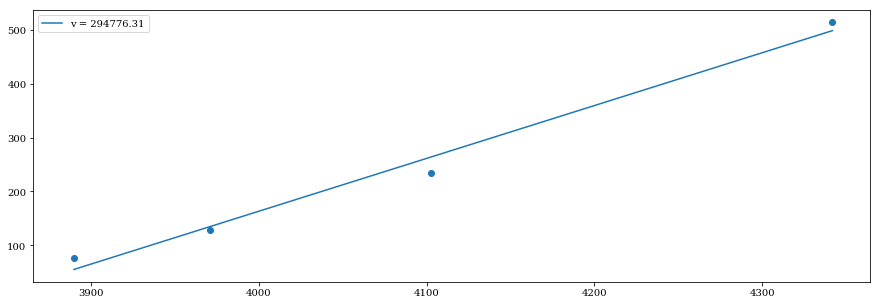

In [20]:
lineGuesses = {'line1':wavepolyfinal(1820),'line2':wavepolyfinal(1345),'line3':wavepolyfinal(1125),'line4':wavepolyfinal(1000)}

def balmer(n):
    R_H = 1.0968 * 10**7
    return (R_H*(1/2**2-1/n**2))**-1*10**10

lineLocs = {}
for i in range(len(lineGuesses)):
    lineLocs['line%d'%(i+1)] = balmer(i+3+2)
    
print(lineLocs)


plt.figure(figsize=[15,5])
plt.errorbar(wavepolyfinal(np.arange(len(hz14[0]))),hz14[0],ms=1,fmt='o',label='object')
plt.errorbar(wavepolyfinal(np.arange(len(hz14[1]))),hz14[1],ms=1,fmt='o',label='sky')
[plt.axvline(lineGuesses[line],c='r',ls='--') for line in lineGuesses]
plt.xlim(wavepolyfinal(0),wavepolyfinal(len(hz14[0])))
plt.legend(loc='best',markerscale=10)
plt.show()

# for line in lineGuesses:
#     plt.figure(figsize=[5,5])
#     plt.errorbar(np.arange(len(hz14[0])),hz14[0],ms=1,fmt='o',label='object')
#     plt.errorbar(np.arange(len(hz14[1])),hz14[1],ms=1,fmt='o',label='sky')
#     plt.axvline(lineGuesses[line],c='r',ls='--')
#     plt.xlim(lineGuesses[line]-50,lineGuesses[line]+50)
#     plt.legend(loc='best',markerscale=10)
#     plt.show()



plt.figure(figsize=[15,5])
wavelengthGuess = []
for line in lineGuesses:
    plt.scatter(lineLocs[line],lineGuesses[line]-lineLocs[line],c='C0')
#     wavelengthGuess.append((lineGuesses[line],lineLocs[line]))
    wavelengthGuess.append((lineLocs[line],lineGuesses[line]-lineLocs[line]))
wavelengthGuess = np.array(wavelengthGuess)

wavefit = np.polyfit(wavelengthGuess[:,0], wavelengthGuess[:,1], 1)
c = 3e5 #km/s
print(wavefit)
vel = wavefit[0]*c
wavepoly = np.poly1d(wavefit)
xvals = np.linspace(wavelengthGuess[:,0].min(),wavelengthGuess[:,0].max())

plt.plot(xvals,wavepoly(xvals),label='v = %.2f'%vel)
#plt.xlim(wavepolyfinal(0),wavepolyfinal(len(hz14[0])))
plt.legend(loc='best')
plt.show()

/Users/kevinm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


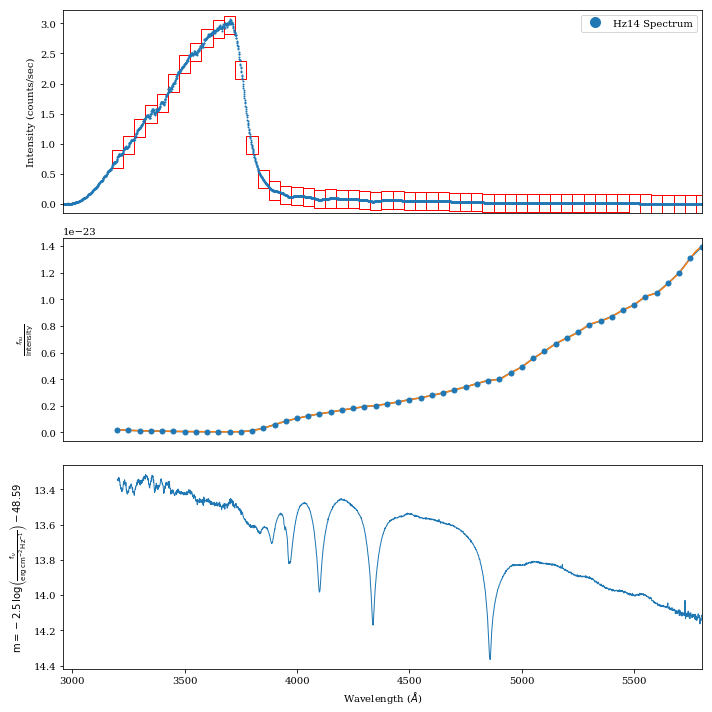

In [21]:
#xvals = wavepolyfinal(np.arange(len(hz14[0])))
xvals = np.polynomial.legendre.legval(np.arange(len(hz14[0])),wavefitfinal_leg)

xbins = np.zeros(len(xvals)+1)
xbins[0] = xvals[0]-(xvals[1]-xvals[0])*0.5
xbins[1:-1] = 0.5*(xvals[1:]+xvals[:-1])
xbins[-1] = xvals[-1]+(xvals[-1]-xvals[-2])*0.5

xbin_widths = xbins[1:]-xbins[:-1]

fluxCalib = np.zeros((len(hz14_calib),4))
for i in range(len(hz14_calib)):
    box = hz14_calib[i][0]-hz14_calib[i][2]/2,hz14_calib[i][0]+hz14_calib[i][2]/2
    inds = (xvals > box[0]) & (xvals < box[1])
    aveCounts = np.sum(xbin_widths[inds]*hz14[0][inds])/np.sum(xbin_widths[inds])
    if not np.isfinite(aveCounts):
        aveCounts = 0
    flux = 10**((hz14_calib[i][1]+48.59)/-2.5)
    #flux = -2.5*np.log10(hz14_calib[i][1])-48.59
    fluxCalib[i] = (box[0],box[1],aveCounts,flux)
    
boxheight = 0.3
plt.figure(figsize=[10,5*2])
ax = plt.subplot(3,1,1)
plt.xticks([])
plt.ylabel('Intensity (counts/sec)')
plt.errorbar(xvals,hz14[0],ms=1,fmt='o',label='Hz14 Spectrum')
ax = plt.gca()
for i in range(len(fluxCalib)):
    if fluxCalib[i][0] > xvals[-1]:
        continue
    rect = mpl.patches.Rectangle((fluxCalib[i][0],fluxCalib[i][2]-boxheight/2),fluxCalib[i][1]-fluxCalib[i][0],boxheight,ec='r',fc='none',lw=1)
    ax.add_patch(rect)
plt.xlim(xvals[0],xvals[-1])
plt.legend(loc='best',markerscale=10)

#plt.figure(figsize=[10,5])
ax = plt.subplot(3,1,2)

ax = plt.gca()
keepCalib = fluxCalib[:,2] > 0
conversion = fluxCalib[keepCalib,3]/fluxCalib[keepCalib,2]
convertX = (0.5*(fluxCalib[keepCalib,1]+fluxCalib[keepCalib,0]))
calibInds = (xvals > convertX.min()) & (xvals < convertX.max())
kind = 'cubic'# linear, slinear, quadratic, cubic
conversionFunc = interpolate.interp1d(convertX,conversion,kind=kind,fill_value=(0,0))
conversionVals = conversionFunc(xvals[calibInds])
plt.errorbar(convertX,conversion,ms=5,fmt='o')
plt.plot(convertX,conversion,c='C0')
plt.plot(xvals[calibInds],conversionVals)
plt.xlim(xvals[0],xvals[-1])
plt.xticks([])
plt.ylabel(r'$\frac{f_{nu}}{\mathrm{Intensity}}$')

    
#plt.figure(figsize=[10,5])
keepCalib = fluxCalib[:,2] > 0
ax = plt.subplot(3,1,3)

ax = plt.gca()
plt.plot(xvals[calibInds],-2.5*np.log10(hz14[0][calibInds]*conversionVals)-48.59,lw=1,label='HZ14')
#plt.errorbar(xvals[calibInds],-2.5*np.log10(hz14[0][calibInds]*conversionVals)-48.59,ms=1,fmt='o',label='HZ14')
plt.xlim(xvals[0],xvals[-1])
#ax.set_yscale('log')
plt.ylabel(r'$\mathrm{m} = -2.5\, \log\left(\frac{\mathrm{f}_{\nu}}{\mathrm{erg}\, \mathrm{cm}^{-2}\, \mathrm{Hz}^{-1}}\right) - 48.59$')
plt.xlabel(r'Wavelength ($\AA$)')
ax.invert_yaxis()
#plt.ylim(15.5,13.25)
#plt.legend(loc='best',markerscale=10)
plt.tight_layout()
plt.savefig('HW5-hz14_fluxcalib.png')
plt.show()
    
flux_calib = np.array([xvals[calibInds],hz14[0][calibInds],hz14[0][calibInds]*conversionVals]).T



In [22]:
def flux_calibrate(star_spec,flux_calib=flux_calib,calibInds=calibInds,plotter=True,starName=''):
    #star_spec in (N,2) of (wavelength,uncalibrated flux)
    #flux_calib in (M,3) of (wavelength,uncalibrated flux,calibrated flux)
    #assumes that star_spec and flux_calib wavelength arrays have 
    #overlapping values 
    results = np.zeros_like(flux_calib)
    results[:,0] = flux_calib[:,0]
    
    results[:,1] = star_spec[:,1][calibInds]*flux_calib[:,1]*flux_calib[:,2]
    
    if plotter:
        plt.figure(figsize=[15,5])
        keepCalib = fluxCalib[:,2] > 0
        ax = plt.gca()
        #plt.plot(flux_calib[:,0],-2.5*np.log10(flux_calib[:,2])-48.59,lw=1,label='Standard (HZ14)')
        if starName != '':
            plt.plot(results[:,0],-2.5*np.log10(results[:,1])-48.59,lw=1,label=starName)
        else:
            plt.plot(results[:,0],-2.5*np.log10(results[:,1])-48.59,lw=1,label='Star')
        plt.xlim(results[0,0],results[-1,0])
        plt.ylabel(r'$\mathrm{m} = -2.5\, \log\left(\frac{\mathrm{f}_{\nu}}{\mathrm{erg}\, \mathrm{cm}^{-2}\, \mathrm{Hz}^{-1}}\right) - 48.59$')
        plt.xlabel(r'$\lambda$ ($\AA$)')
        plt.xlim(star_spec[0,0],star_spec[-1,0])
        ax.invert_yaxis()
        #plt.ylim(14.4,13.25)

        plt.legend(loc='best')
        plt.show()

    return results





In [23]:
hgamma = balmer(5)
wd_files = ['LB1839_praesepe.fits',
            'n2168_RA3.fits',
            'n2168_RA4.fits',
            'n2168_vH1.fits',
            'n2168_WB1.fits',
            'n2168_WB2a.fits',
            'n2168_WB2b.fits',
            'n2168_WB3.fits',
            'n2168_WB4.fits',
            'n2168_WB5.fits',
            'n2168_WB6.fits',
            'n2168_WB7.fits',
            'n2168_WB9.fits',
            'n2168_WBB2a.fits',
            'n2168_WBB2b.fits',
            'PG0048+202.fits',
            'WD0001+433.fits',
            'WD0834_praesepe.fits',
            'WD0937+505.fits',
            'WD1105-048.fits']
for wd in wd_files:
    test = extractSpectrum(wd,path=path,plotter=False)
    star_spec = np.array([xvals,test[0]]).T
    flux_calibrate(star_spec,starName=wd,plotter=False)


/Users/kevinm/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/kevinm/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


/Users/kevinm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log10
/Users/kevinm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


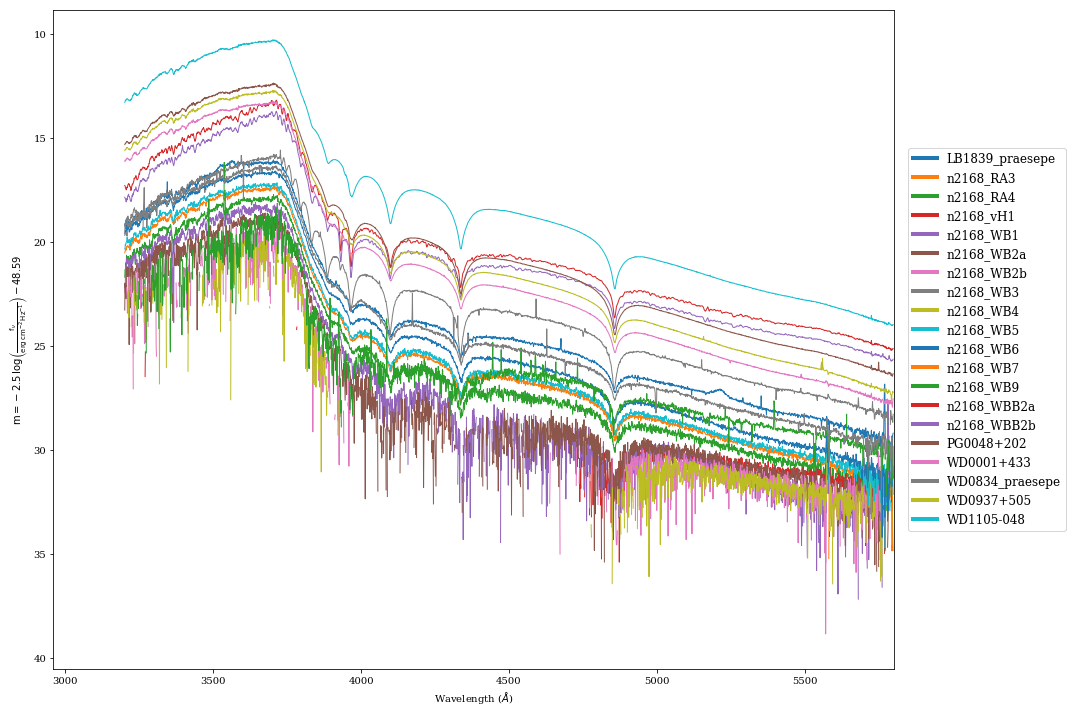

In [24]:
plotter=True
#plt.figure(figsize=[15,5*2/3*len(wd_files)])
plt.figure(figsize=[15,10])

finalSpectra = {}
for i,wd in enumerate(wd_files):
    test = extractSpectrum(wd,path=path,plotter=False)
    star_spec = np.array([xvals,test[0]]).T
    starName = wd.split('.')[0]
    
    results = np.zeros_like(flux_calib)
    results[:,0] = flux_calib[:,0]

    results[:,1] = star_spec[:,1][calibInds]*flux_calib[:,1]*flux_calib[:,2]
    finalSpectra[wd] = results
    if plotter:
        if i == 0:
            ax = plt.gca()
            ax.invert_yaxis()

        keepCalib = fluxCalib[:,2] > 0
        
        #plt.plot(flux_calib[:,0],-2.5*np.log10(flux_calib[:,2])-48.59,lw=1,label='Standard (HZ14)')
        if starName != '':
            plt.plot(results[:,0],-2.5*np.log10(results[:,1])-48.59,lw=1,label=starName)
        else:
            plt.plot(results[:,0],-2.5*np.log10(results[:,1])-48.59,lw=1,label='Star')
    
#plt.xlim(results[0,0],results[-1,0])
plt.ylabel(r'$\mathrm{m} = -2.5\, \log\left(\frac{\mathrm{f}_{\nu}}{\mathrm{erg}\, \mathrm{cm}^{-2}\, \mathrm{Hz}^{-1}}\right) - 48.59$')
plt.xlabel(r'Wavelength ($\AA$)')
plt.xlim(star_spec[0,0],star_spec[-1,0])
#plt.ylim(14.4,13.25)

leg = plt.legend(loc=6, markerscale=10, bbox_to_anchor=(1.01, 0.5), ncol=1, fontsize=12)
for line in leg.get_lines():
    line.set_linewidth(4.0)
    
plt.tight_layout()
plt.savefig('HW5-allspectra.png', bbox_extra_artists=(leg,), bbox_inches='tight')

plt.show()

In [25]:
hgamma
def lorentz(x,*params):
    A, x0, gamma, a, b, c = params
    return a*np.power(x,2)+b*x+c+ A*(0.5*gamma*(1/np.pi)/(np.power(x-x0,2)+np.power(0.5*gamma,2)))

def lorentz_only(x,*params):
    A, x0, gamma = params
    return 1+A*(0.5*gamma*(1/np.pi)/(np.power(x-x0,2)+np.power(0.5*gamma,2)))

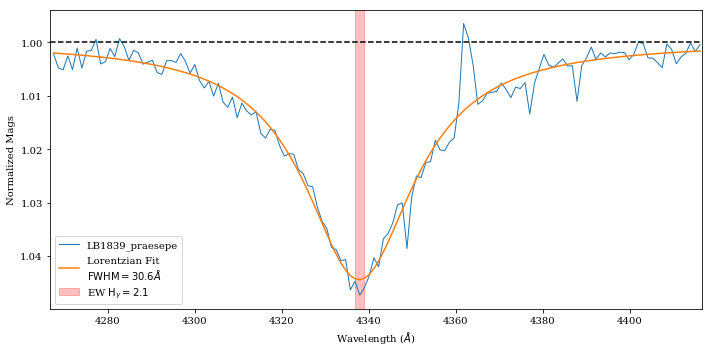

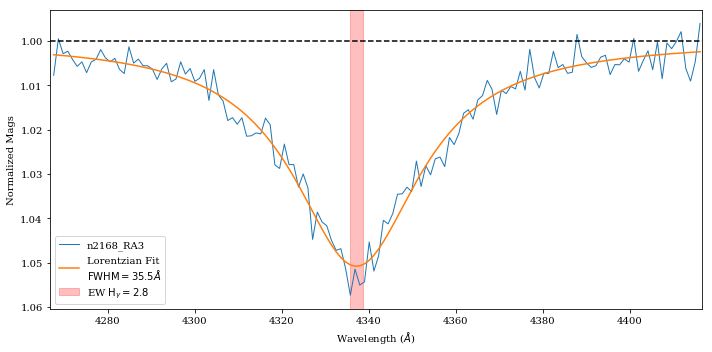

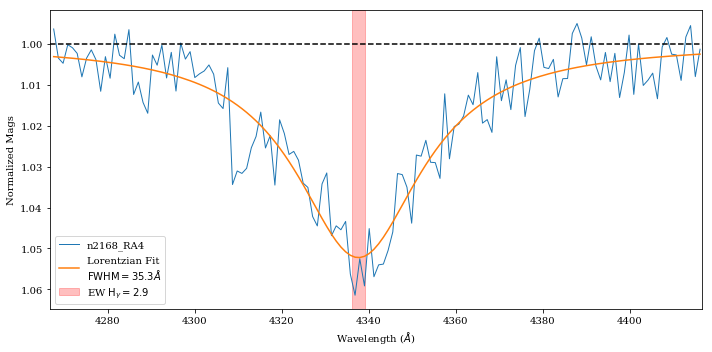

/Users/kevinm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10


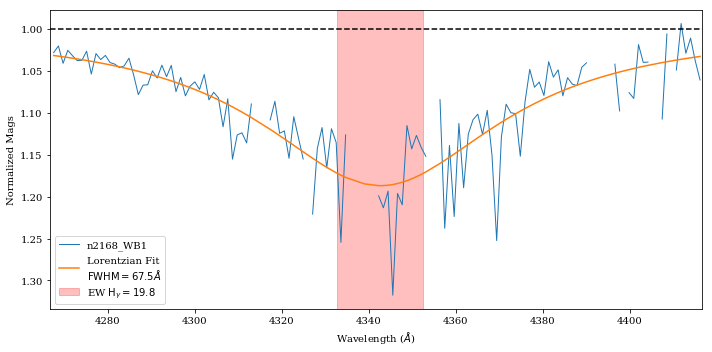

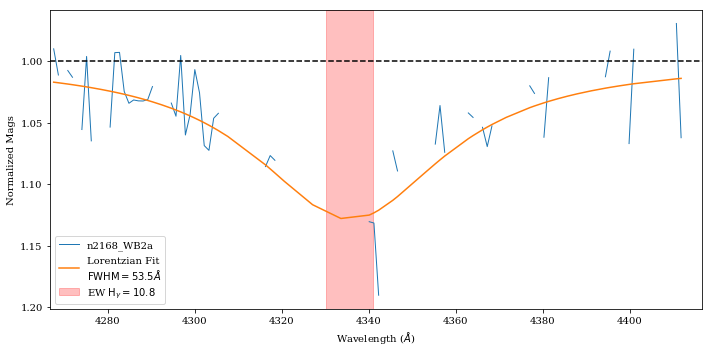

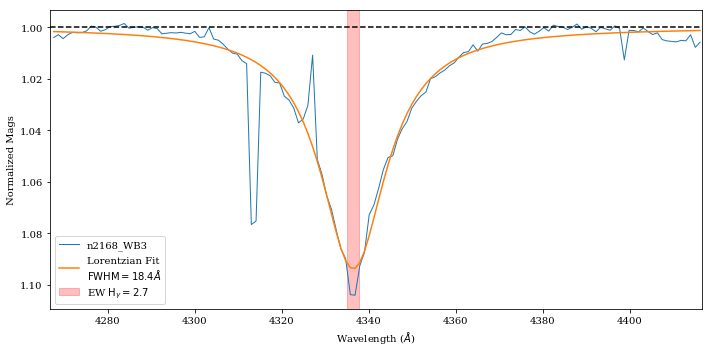

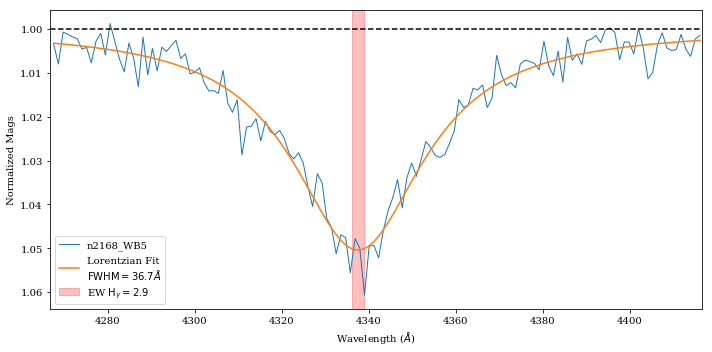

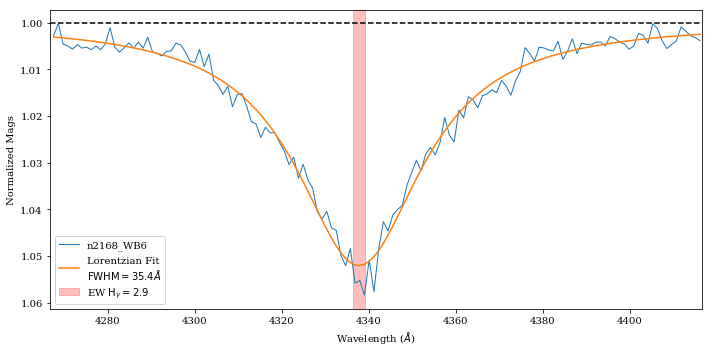

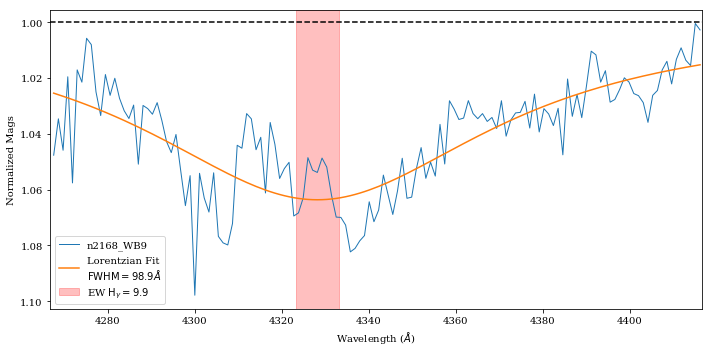

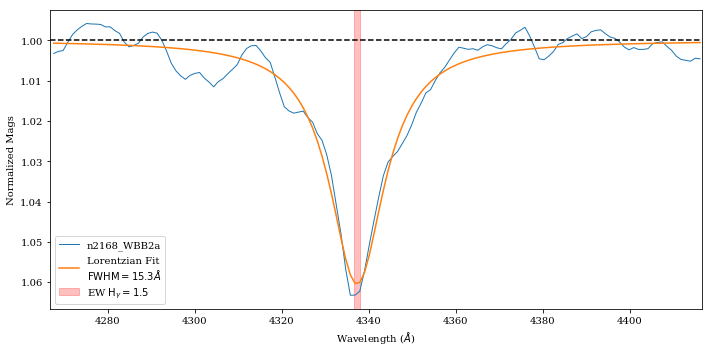

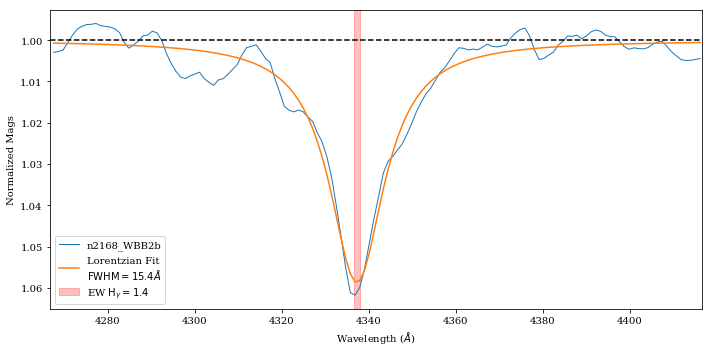

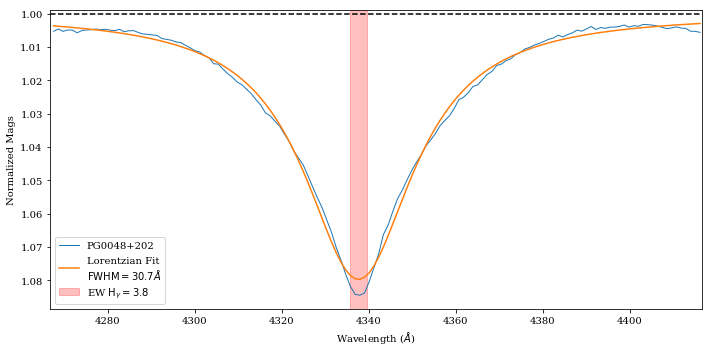

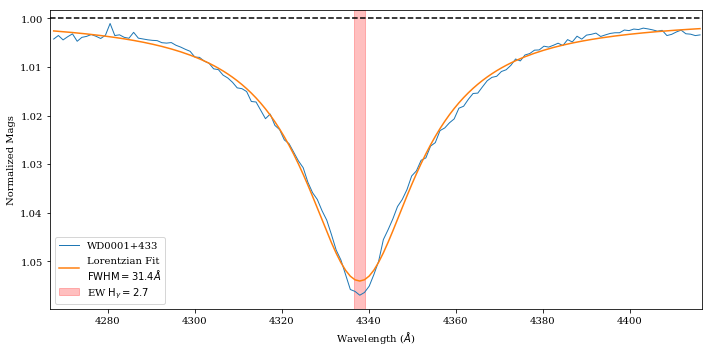

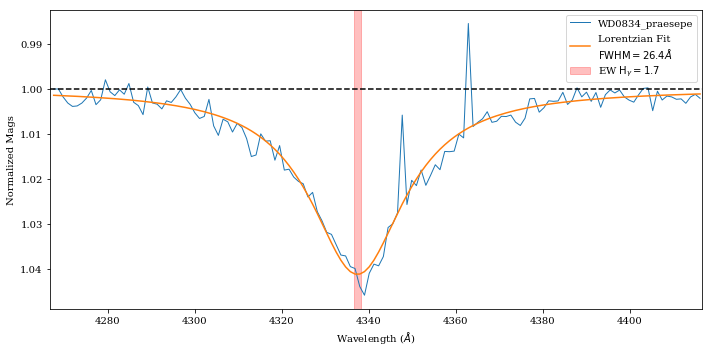

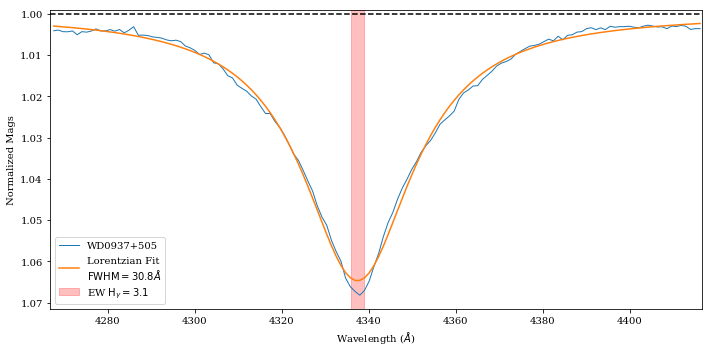

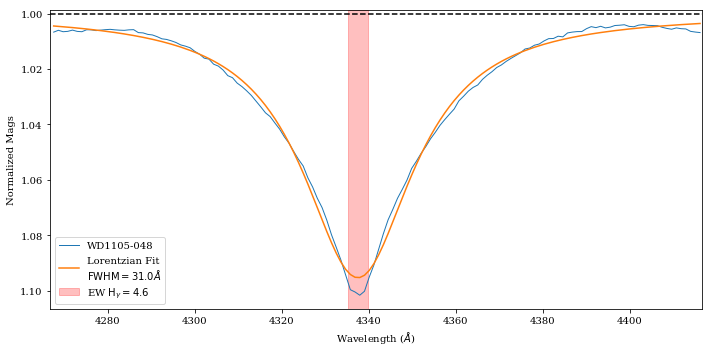

In [26]:
shift = 75
width = 1 #arcsec

def smoothing(x,y,width):
    npad = width*5
    newy = np.zeros_like(y)
    for i,xval in enumerate(x):
        dx = x-xval
        weights = np.exp(-0.5*np.power(dx,2)/width**2)
        weights /= np.sum(weights)
        newy[i] = np.sum(y*weights)
    return newy

lorentzParams = {}
for i,wd in enumerate(wd_files):
    starName = wd.split('.')[0]
    results = finalSpectra[wd] 
    region = (results[:,0] > hgamma-shift) & (results[:,0] < hgamma+shift)
    smoothed = smoothing(results[:,0],results[:,1],width)
    mags = -2.5*np.log10(results[:,1][region])-48.59
    if np.all(np.logical_not(np.isfinite(mags))):
        continue
    keepmags = np.isfinite(mags)

    #plt.plot(results[:,0][region],-2.5*np.log10(smoothed[region])-48.59,lw=1,label='Smoothed')
    argmax = np.argmax(mags)
    
    xslice,yslice = results[:,0][region][keepmags],np.copy(mags)[keepmags]
    p0 = [(np.max(yslice)-np.min(yslice))*50, xslice[np.argmax(yslice)], 50., 0, 0, np.min(yslice)]
    try:
        coeff, var_matrix = curve_fit(lorentz,xslice,yslice,p0=p0)
    except:
        print('Fitting failed for',wd)
        continue
        
    continuum = np.power(results[:,0][region],2)*coeff[-3] + results[:,0][region]*coeff[-2] + coeff[-1]
    resids = mags/continuum
        
    plt.figure(figsize=[10,5])
    A, x0, gamma = coeff[:3]
    p0 = coeff[:3]
    coeff, var_matrix = curve_fit(lorentz_only,xslice,resids[keepmags],p0=p0)
    lorentzParams[wd] = coeff

    plt.plot(results[:,0][region],resids,lw=1,label=starName)
    #A*(0.5*gamma*(1/np.pi)/(np.power(x-x0,2)+np.power(0.5*gamma,2)))
    
#     dx = np.zeros_like(results[:,0][region])
#     dx[1:] = results[:,0][region][1:] - results[:,0][region][:-1]
#     dx[0] = dx[1]
#     ew = np.sum((continuum-profile)/continuum*dx)

    plt.ylabel('Normalized Mags')
    plt.xlabel('Wavelength ($\AA$)')
    #plt.plot(xslice,lorentz(xslice,*lorentzParams[wd])/continuum[keepmags],c='C1',label='Lorentzian Fit\n$\mathrm{FWHM} = %.1f \AA$'%coeff[2])
    plt.plot(xslice,lorentz_only(xslice,*coeff),c='C1',label='Lorentzian Fit\n$\mathrm{FWHM} = %.1f \AA$'%coeff[2])
    plt.axhline(1,c='k',ls='--')
    window = coeff[1]-0.5*coeff[0],coeff[1]+0.5*coeff[0]
    ylim = plt.ylim()
    plt.axvspan(window[0], window[1], alpha=0.25, color='red',label='EW $\mathrm{H}_\gamma = %.1f$'%coeff[0])

    plt.xlim(hgamma-shift,hgamma+shift)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.legend(loc='best')
    plt.tight_layout()
    if wd == 'n2168_WB6.fits':
        plt.savefig('HW5-hgamma_fit.png')
    plt.show()
    

In [27]:
for i,wd in enumerate(wd_files):
    #prints filename, equivalent width, and fwhm
    if wd in lorentzParams:
        print(wd,'&',round(lorentzParams[wd][0],1),'&',round(lorentzParams[wd][2],1),'\\\\')

LB1839_praesepe.fits & 2.1 & 30.6 \\
n2168_RA3.fits & 2.8 & 35.5 \\
n2168_RA4.fits & 2.9 & 35.3 \\
n2168_WB1.fits & 19.8 & 67.5 \\
n2168_WB2a.fits & 10.8 & 53.5 \\
n2168_WB3.fits & 2.7 & 18.4 \\
n2168_WB5.fits & 2.9 & 36.7 \\
n2168_WB6.fits & 2.9 & 35.4 \\
n2168_WB9.fits & 9.9 & 98.9 \\
n2168_WBB2a.fits & 1.5 & 15.3 \\
n2168_WBB2b.fits & 1.4 & 15.4 \\
PG0048+202.fits & 3.8 & 30.7 \\
WD0001+433.fits & 2.7 & 31.4 \\
WD0834_praesepe.fits & 1.7 & 26.4 \\
WD0937+505.fits & 3.1 & 30.8 \\
WD1105-048.fits & 4.6 & 31.0 \\


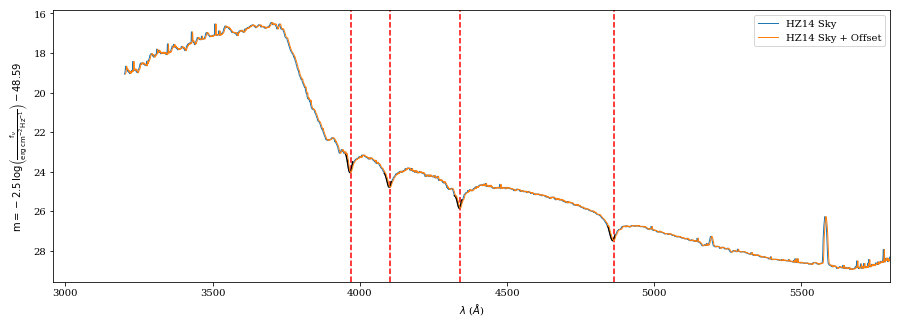

In [28]:
sky_spec = np.zeros_like(flux_calib)
sky_spec[:,0] = flux_calib[:,0]

sky_spec[:,1] = hz14[1][calibInds]*flux_calib[:,1]*flux_calib[:,2]

plt.figure(figsize=[15,5])
ax = plt.gca()
sky_mags = -2.5*np.log10(sky_spec[:,1])-48.59
plt.plot(sky_spec[:,0],sky_mags,lw=1,label='HZ14 Sky')
plt.xlim(xvals[0],xvals[-1])
plt.ylabel(r'$\mathrm{m} = -2.5\, \log\left(\frac{\mathrm{f}_{\nu}}{\mathrm{erg}\, \mathrm{cm}^{-2}\, \mathrm{Hz}^{-1}}\right) - 48.59$')
plt.xlabel(r'$\lambda$ ($\AA$)')
ax.invert_yaxis()

def gauss3(x,*params):
    A,mu,sig,b = params
    return A*np.exp(-0.5*np.power((x-mu)/sig,2))+b

waveoffset = np.zeros((4,2))
for i in range(4,8):
    balmerLine = balmer(i)
    plt.axvline(balmerLine,c='r',ls='--')
    sliceInds = np.where((sky_spec[:,0] > balmerLine-20) & (sky_spec[:,0] < balmerLine+5))
    argmax = np.argmax(sky_mags[sliceInds])

    xslice,yslice = sky_spec[:,0][sliceInds],sky_mags[sliceInds]
    #p0 = [np.max(yslice)-np.min(yslice), xslice[np.argmax(yslice)], 5., 0, np.min(yslice)]
    p0 = [np.max(yslice)-np.min(yslice), xslice[np.argmax(yslice)], 5., np.min(yslice)]

    coeff, var_matrix = curve_fit(gauss3,xslice,yslice,p0=p0)
    plt.plot(xslice,gauss3(xslice,*coeff),c='k')
    waveoffset[i-4] = (balmerLine-coeff[1],np.sqrt(var_matrix[1][1]))
    #plt.axvline(sky_spec[:,0][sliceInds][argmax],c='m',ls='--')
waveoffset_ave = np.average(waveoffset[:,0],weights=1/np.power(waveoffset[:,1],2))
#print(waveoffset_ave)

plt.plot(sky_spec[:,0]+waveoffset_ave,sky_mags,lw=1,label='HZ14 Sky + Offset')
# i = 7
# balmerLine = balmer(i)
# plt.xlim(sky_spec[:,0][(sky_spec[:,0] > balmerLine-20)][0]-50,sky_spec[:,0][(sky_spec[:,0] < balmerLine+5)][-1]+50)
# plt.ylim(25,23)

plt.legend(loc='best')
plt.show()


